## Imports

In [188]:
import pandas as pd
import numpy as np

from time import perf_counter

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from scipy.linalg import svd

from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import cho_factor, cho_solve
from scipy.linalg import qr, solve_triangular

import scipy.stats

from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

## Load in data

In [3]:
df = pd.read_csv('./Concrete_Data.csv')
col_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'age', 'strength']
df.columns = col_names
df

,c1,c2,c3,c4,c5,c6,c7,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Exploratory Data Analysis

In [4]:
df.describe()

,c1,c2,c3,c4,c5,c6,c7,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
df.isna().sum()

c1          0
c2          0
c3          0
c4          0
c5          0
c6          0
c7          0
age         0
strength    0
dtype: int64

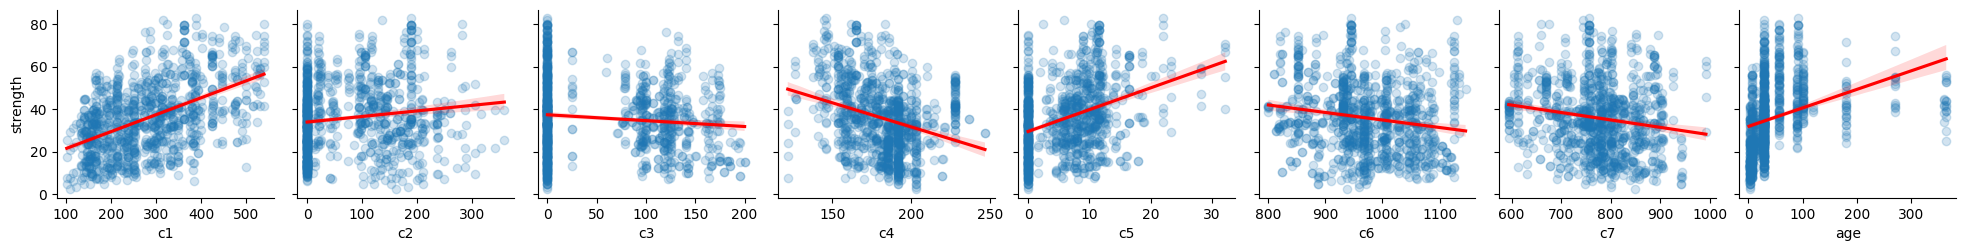

In [5]:
sns.pairplot(df, y_vars = col_names[-1], x_vars = col_names[:-1], kind = 'reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2}})

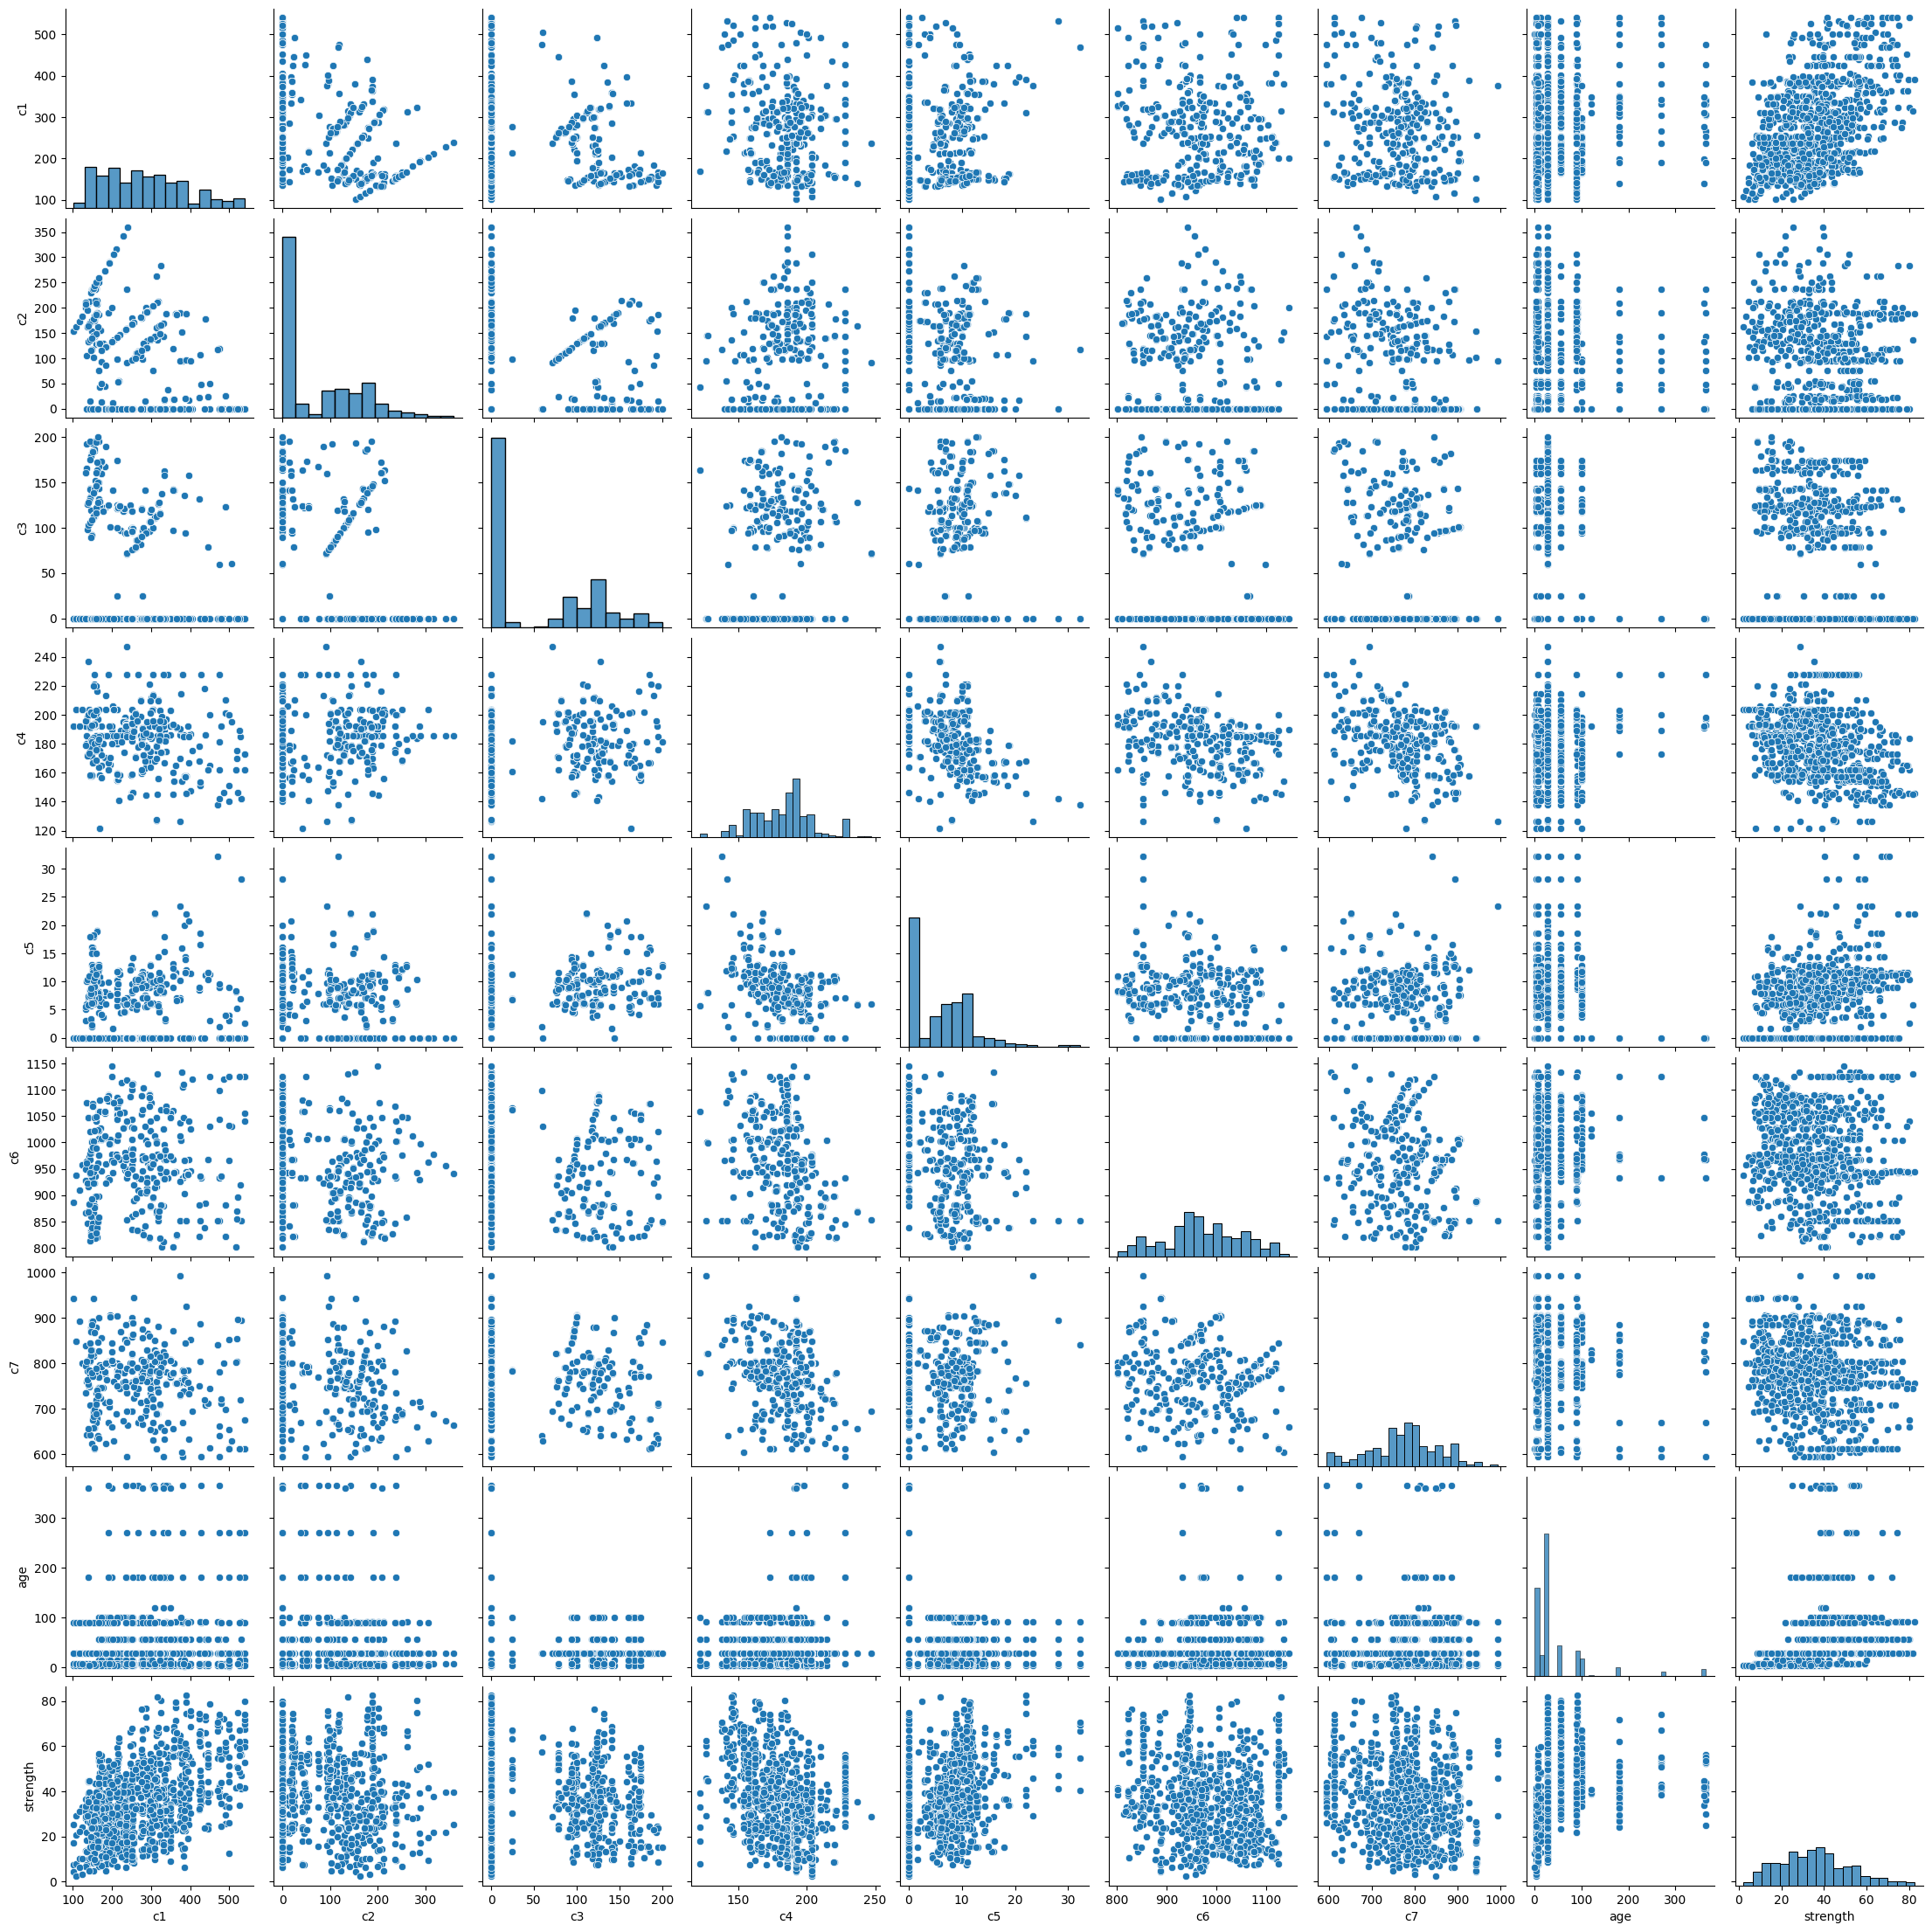

In [6]:
sns.pairplot(df)

In [7]:
plt.spy(X, aspect='auto')

NameError: name 'X' is not defined

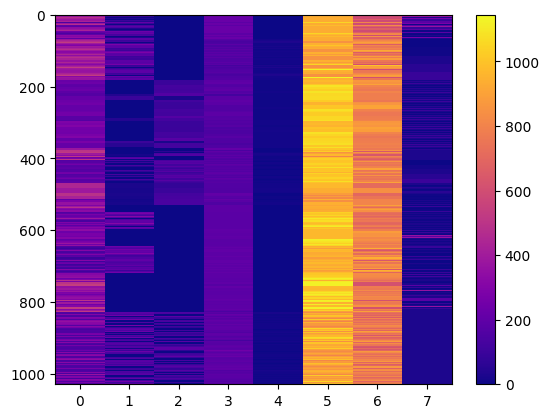

In [381]:
plt.imshow(X,interpolation='none',cmap='plasma', aspect='auto')
plt.colorbar()

## Data Preprocessing

### Extract X and Y

In [6]:
df_n = df.shape[0]

In [7]:
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy().reshape(df_n, 1)

### Split into train and test subsets

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=156)

### Scale Data

In [9]:
X_scaled = preprocessing.StandardScaler().fit_transform(X_train)
Y_scaled = preprocessing.StandardScaler().fit_transform(Y_train)

## Linear Regression

In [10]:
A = X_scaled.T @ X_scaled
b = X_scaled.T @ Y_scaled

In [11]:
A_n = A.shape[0]

In [130]:
def retrieve_coef(beta, x, y):
    ''' 
    Function to retrieve the unscaled betas and intercept.
    Beta is an (n x 1) vector containing the beta estimates from scaled data.
    X is the unscaled X array (with no intercept column).
    Y is the unscaled Y array.

    The output is an (n+1 x 1) containin the intercept and beta estimates.
    '''
    # add intercept
    beta = np.vstack((0, beta))
    
    # calculate coefficients
    ret_coef = np.std(y) / np.std(x, axis=0) * beta.ravel()[1:] 
    n = len(ret_coef)
    ret_coef = ret_coef.reshape((n, 1))

    # calculate intecept
    y_bar = np.mean(y)
    x_bars = np.mean(x, axis=0)

    betax = []

    for a, b in zip(ret_coef, x_bars):
        betax.append(a*b)

    sum_betax = np.sum(betax)
    
    beta0 = y_bar - sum_betax

    # combine intercept and coefficients
    coef = np.vstack((beta0, ret_coef))

    return coef

### LU

In [13]:
def LU(A, b):
    start = perf_counter()

    lu, piv = lu_factor(A)
    x = lu_solve((lu, piv), b)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [145]:
result_lu = LU(A, b)
beta_lu= result_lu['x']
coef_lu = retrieve_coef(beta_lu, X_train, Y_train)
coef_lu

array([[-3.81099198e+01],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786137e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936709e-02],
       [ 2.50738277e-02],
       [ 1.11873182e-01]])

### Cholesky

In [15]:
def Cholesky(A, b):
    start = perf_counter()

    c, low = cho_factor(A, lower=True)
    x = cho_solve((c, low), b)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [133]:
result_cho = Cholesky(A, b)
beta_cho = result_cho['x']

retrieve_coef(beta_cho, X_train, Y_train)

array([[-3.81099198e+01],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786137e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936709e-02],
       [ 2.50738277e-02],
       [ 1.11873182e-01]])

### QR

In [17]:
def QR(A, b):
    start = perf_counter()

    q, r = qr(A)
    z = q.T @ b
    x = solve_triangular(r, z)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [134]:
result_qr = QR(A, b)
beta_qr = result_qr['x']

retrieve_coef(beta_qr, X_train, Y_train)

array([[-3.81099198e+01],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786137e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936709e-02],
       [ 2.50738277e-02],
       [ 1.11873182e-01]])

### Jacobi

In [19]:
def jacobi(A, x, b):
   start = perf_counter()
    
   D = np.diag(A)
   R = A - np.diagflat(D)

   while np.linalg.norm(A @ x - b) > 1e-3:
      x = (b - np.dot(R, x)) / D

   end = perf_counter()
   time = end - start

   result = {'x': x, 
              'time': time}
   return result

In [135]:
# initial guess
beta0 = np.full((A_n, 1), 1/A_n)

# run Jacobi algorithm
result_jacobi = jacobi(A, beta0, b)
beta_jacobi = result_jacobi['x']
beta_jacobi

C:\Users\Connor\AppData\Local\Temp\ipykernel_14624\1089718647.py:7: RuntimeWarning: overflow encountered in matmul
C:\Users\Connor\AppData\Local\Temp\ipykernel_14624\1089718647.py:7: RuntimeWarning: invalid value encountered in matmul


array([[ 3.47372987e+304,  3.47372987e+304,  3.47372987e+304,
         3.47372987e+304,  3.47372987e+304,  3.47372987e+304,
         3.47372987e+304,  3.47372987e+304],
       [ 9.83182773e+304,  9.83182773e+304,  9.83182773e+304,
         9.83182773e+304,  9.83182773e+304,  9.83182773e+304,
         9.83182773e+304,  9.83182773e+304],
       [-1.85369630e+305, -1.85369630e+305, -1.85369630e+305,
        -1.85369630e+305, -1.85369630e+305, -1.85369630e+305,
        -1.85369630e+305, -1.85369630e+305],
       [             inf,              inf,              inf,
                     inf,              inf,              inf,
                     inf,              inf],
       [            -inf,             -inf,             -inf,
                    -inf,             -inf,             -inf,
                    -inf,             -inf],
       [ 1.11574120e+304,  1.11574120e+304,  1.11574120e+304,
         1.11574120e+304,  1.11574120e+304,  1.11574120e+304,
         1.11574120e+304,  1.11

Does not converge.

### Gauss-Seidel

In [57]:
def gauss_seidel(A, b, k=250, epsilon=1e-6, x=None):
    start = perf_counter()

    n = A.shape[0]

    if not x:
        x = np.full((n, 1), 1/n)

    for _ in range(k):
        new_x = np.zeros(n)
        for j in range(n):
            ax1 = np.dot(A[j, :j], new_x[:j])
            ax = np.dot(A[j, j+1:], x[j+1:])
            new_x[j] = (b[j] - ax1 - ax) / A[j, j]
        
        if np.allclose(x, new_x, rtol = epsilon, atol = epsilon):
            return x.reshape(n, 1)
        
        x = new_x.reshape(n, 1)

    end = perf_counter()
    time = end - start    

    result = {'x': x, 
              'time': time}
    return result

In [136]:
beta0 = np.full((A_n, 1), 1/A_n)

result_gauss = gauss_seidel(A, b, k=250, epsilon=1e-6)
beta_gauss = result_gauss['x']

retrieve_coef(beta_gauss, X_train, Y_train)

array([[-3.81099068e+01],
       [ 1.26157798e-01],
       [ 1.10049305e-01],
       [ 9.56786082e-02],
       [-1.21655871e-01],
       [ 3.43872331e-01],
       [ 2.11936667e-02],
       [ 2.50738227e-02],
       [ 1.11873181e-01]])

### Successive over-relaxation (SOR)

In [23]:
def SOR(A, b, w, k=250, epsilon=1e-6, x=None):
    start = perf_counter() 

    n = A.shape[0]

    if not x:
        x = np.full((n, 1), 1/n)

    for _ in range(k):
        new_x = np.zeros(n)
        for j in range(n):
            ax1 = np.dot(A[j, :j], new_x[:j])
            ax = np.dot(A[j, j+1:], x[j+1:])
            new_x[j] = (w * (b[j] - ax1 - ax) / A[j, j]) + (1-w)*x[j]

        if np.allclose(x, new_x, rtol = epsilon, atol = epsilon):
            return x.reshape(n, 1)
        
        x = new_x.reshape(n, 1)
    
    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [137]:
w = 0.5
result_SOR = SOR(A, b, w, 1000, 1e-10)
beta_SOR = result_SOR['x']
retrieve_coef(beta_SOR, X_train, Y_train)

array([[-3.81099196e+01],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786136e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936708e-02],
       [ 2.50738276e-02],
       [ 1.11873182e-01]])

### SVD

In [79]:
def SVD(A, b):
    start = perf_counter()

    U, s, Vh = svd(A)
    s = np.diagflat(s)
    x = Vh.T @ np.reciprocal(s, where=s!=0, out=np.zeros_like(s)) @ U.T @ b

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [138]:
result_svd = SVD(A, b)
beta_svd = result_svd['x']

retrieve_coef(beta_svd, X_train, Y_train)

array([[-3.81099198e+01],
       [ 1.26157802e-01],
       [ 1.10049310e-01],
       [ 9.56786137e-02],
       [-1.21655854e-01],
       [ 3.43872340e-01],
       [ 2.11936709e-02],
       [ 2.50738277e-02],
       [ 1.11873182e-01]])

## Model Accuracy

In [191]:
def predict_score(model, x_test, y_test):
    n, p = x_test.shape
    
    x_test = np.hstack((np.ones((n, 1)), x_test))
    p += 1
    
    y_pred = x_test @ model

    resids = y_test - y_pred

    y_bar = np.mean(y_test)

    mse = np.sum([(y - y_hat)**2 for y, y_hat in zip(y_test, y_pred)]) / (n-p)

    msto = np.sum([(y - y_bar)**2 for y in y_test]) / (n-1)

    msr = (msto*(n-1) - mse*(n-p)) / (p-1)

    r2 = (msr*(p-1)) / (msto*(n-1))

    r2_adj = 1 - (mse/msto)

    Fstat = msr/mse

    Fpval = 1 - scipy.stats.f.cdf(Fstat, p-1, n-p)

    shapiro = scipy.stats.shapiro(x_test)[1]

    durbin = durbin_watson(resids)[0]
    
    results = {
        'preds': y_pred,
        'resids': resids,
        'R2': r2,
        'R2_Adj': r2_adj,
        'MSE': mse,
        'F-statistic': Fstat,
        'F-statistic P-value': Fpval,
        'Shapiro-Wilks P-value': shapiro,
        'Durbin-Watson': durbin
    }
    return results

In [192]:
predict_score(coef_lu, X_train, Y_train)

{'preds': array([[35.13893432],
        [54.91972798],
        [36.9452808 ],
        [47.39081658],
        [28.62689085],
        [22.26693766],
        [28.30914653],
        [48.60724595],
        [29.22336044],
        [37.93576386],
        [26.00958466],
        [22.87950761],
        [15.45571145],
        [31.22313933],
        [26.79722497],
        [42.39592578],
        [38.29105988],
        [40.30115369],
        [31.3423582 ],
        [57.98919015],
        [34.03687627],
        [33.86618234],
        [36.41487641],
        [19.81924643],
        [24.71570292],
        [61.51500715],
        [33.40078983],
        [55.31927572],
        [13.56972842],
        [40.59905478],
        [23.0980459 ],
        [15.97146118],
        [49.46341169],
        [31.22548974],
        [18.43034655],
        [31.27112438],
        [49.05156833],
        [22.35572942],
        [51.67016717],
        [45.90933079],
        [31.8563057 ],
        [27.30090397],
        [13.59091096],
  

In [143]:
import statsmodels.api as sm

In [144]:
test_ols = sm.OLS(Y_train, sm.add_constant(X_train)).fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     161.3
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          2.23e-158
Time:                        16:34:51   Log-Likelihood:                -2889.8
No. Observations:                 772   AIC:                             5798.
Df Residuals:                     763   BIC:                             5840.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.1099     30.530     -1.248      0.212     -98.043      21.823
x1             0.1262      0.010     13.010      0.000       0.107       0.145
x2             0.1100      0.012      9.459      0.000       0.087       0.133
x3             0.0957      0.014      6.667      0.000       0.068       0.124
x4            -0.1217      0.047     -2.609      0.009      -0.213      -0.030
x5             0.3439      0.110      3.120      0.002       0.128       0.560
x6             0.0212      0.011      1.975      0.049       0.000       0.042
x7             0.0251      0.012      2.051      0.041       0.001       0.049
x8             0.1119      0.006     18.915      0.000       0.100       0.123
==============================================================================
Omnibus:                        5.546   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.635
Skew:                          -0.197   Prob(JB):                       0.0598
Kurtosis:                       2.859   Cond. No.                     1.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Computation Speed Comparison

In [52]:
def speedTest(func, A, b, n, **kwargs):
    times = [func(A, b, **kwargs)['time'] for _ in range(n)]
    mean = np.mean(times)
    return mean
    

In [67]:
# LU
mean_lu = speedTest(LU, A, b, n=1000)
mean_lu

1.17688999598613e-05

In [68]:
# Cholesky
mean_cho = speedTest(Cholesky, A, b, n=1000)
mean_cho

1.741580021189293e-05

In [69]:
# QR
mean_qr= speedTest(QR, A, b, n=1000)
mean_qr

4.612049994466361e-05

In [70]:
# Gauss-Seidel
mean_gauss = speedTest(gauss_seidel, A, b, n=1000)
mean_gauss

0.020894146999904478

In [72]:
# SOR, w = 0.25
mean_sor_025  = speedTest(SOR, A, b, n=1000, w=0.25)
mean_sor_025

0.027133807400074147

In [71]:
# SOR, w = 0.5
mean_sor_05 = speedTest(SOR, A, b, n=1000, w=0.5)
mean_sor_05

0.02736342479995801

In [73]:
# SOR, w = 0.75
mean_sor_075 = speedTest(SOR, A, b, n=1000, w=0.75)
mean_sor_075

0.027139279699993496

In [75]:
# SOR, w = 1
mean_sor_1 = speedTest(SOR, A, b, n=1000, w=1)
mean_sor_1

0.029098607299747527

In [74]:
# SOR, w = 1.25
mean_sor_125 = speedTest(SOR, A, b, n=1000, w=1.25)
mean_sor_125

0.027113428499964357

In [76]:
# SOR, w = 1.5
mean_sor_15 = speedTest(SOR, A, b, n=1000, w=1.5)
mean_sor_15

0.027261433099971328

In [77]:
# SOR, w = 1.75
mean_sor_175 = speedTest(SOR, A, b, n=1000, w=1.75)
mean_sor_175

0.027399155899998733

In [81]:
# SVD
mean_svd = speedTest(SVD, A, b, n=1000)
mean_svd

6.26824999199016e-05